In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
from PIL import Image
from tensorflow.keras import regularizers  # Import regularizers module
from tensorflow.keras.regularizers import l2  # Import l2 from regularizers submodule

In [2]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 309M/309M [00:16<00:00, 21.0MB/s]
100% 309M/309M [00:16<00:00, 19.5MB/s]


In [3]:
!unzip "/content/human-emotions-datasethes.zip"


Streaming output truncated to the last 5000 lines.
  inflating: EmotionsDataset/data/nothing/720.jpg  
  inflating: EmotionsDataset/data/nothing/721.jpg  
  inflating: EmotionsDataset/data/nothing/722.jpg  
  inflating: EmotionsDataset/data/nothing/723.jpg  
  inflating: EmotionsDataset/data/nothing/724.jpg  
  inflating: EmotionsDataset/data/nothing/725.jpg  
  inflating: EmotionsDataset/data/nothing/726.jpg  
  inflating: EmotionsDataset/data/nothing/727.jpg  
  inflating: EmotionsDataset/data/nothing/728.jpg  
  inflating: EmotionsDataset/data/nothing/729.jpg  
  inflating: EmotionsDataset/data/nothing/73.jpg  
  inflating: EmotionsDataset/data/nothing/730.jpg  
  inflating: EmotionsDataset/data/nothing/731.jpg  
  inflating: EmotionsDataset/data/nothing/732.jpg  
  inflating: EmotionsDataset/data/nothing/733.jpg  
  inflating: EmotionsDataset/data/nothing/734.jpg  
  inflating: EmotionsDataset/data/nothing/735.jpg  
  inflating: EmotionsDataset/data/nothing/736.jpg  
  inflating: E

In [2]:
train_directory = "/content/path/to/augmented_dataset"
test_directory = "/content/Emotions Dataset/Emotions Dataset/test"

In [3]:

Batch_size = 64


In [6]:
input_dir = '/content/Emotions Dataset/Emotions Dataset/train'
output_dir = '/content/path/to/augmented_dataset'
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
os.makedirs(output_dir, exist_ok=True)
for class_label in ['angry', 'happy', 'sad']:
    class_dir = os.path.join(input_dir, class_label)
    if not os.path.isdir(class_dir):
        print(f"Skipping {class_label}: Not a directory")
        continue
    class_output_dir = os.path.join(output_dir, class_label)
    os.makedirs(class_output_dir, exist_ok=True)

    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)


        try:
            image = load_img(image_path)
        except Exception as e:
            print(f"Error loading image {image_name}: {e}")
            continue

        image_array = img_to_array(image)
        image_array = np.expand_dims(image_array, axis=0)


        aug_iter = datagen.flow(image_array, batch_size=1)
        for i in range(5):
            augmented_image = next(aug_iter)[0].astype('uint8')


            augmented_image_name = f"{os.path.splitext(image_name)[0]}_aug_{i}.jpg"
            augmented_image_path = os.path.join(class_output_dir, augmented_image_name)
            Image.fromarray(augmented_image).save(augmented_image_path)


In [4]:
CLASS_NAMES=["angry", "happy", "sad"]
IM_SIZE=256

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=Batch_size,
    image_size=(IM_SIZE,IM_SIZE),
    shuffle=True,
    seed=99,
)

Found 33995 files belonging to 3 classes.


In [6]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=Batch_size,
    image_size=(IM_SIZE, IM_SIZE),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


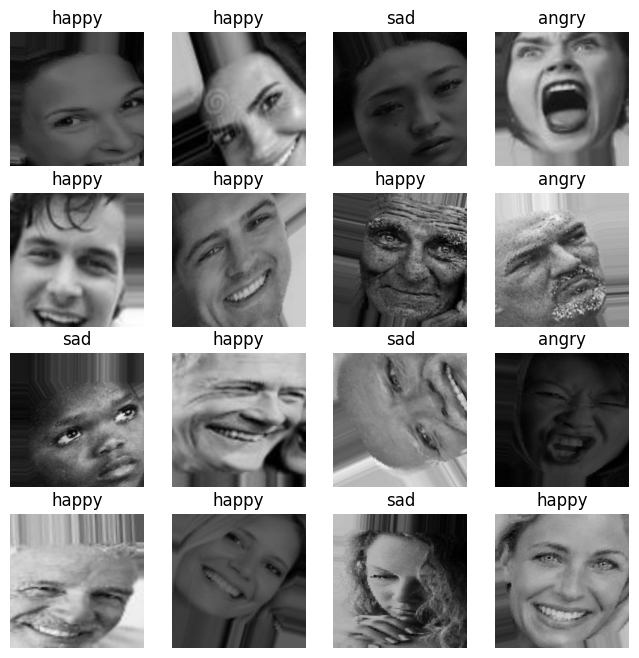

In [7]:
plt.figure(figsize = (8,8))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

In [12]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IM_SIZE, IM_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
predictions = Dense(len(CLASS_NAMES), activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 53,582,915 (204.40 MB)

 Trainable params: 33,558,531 (128.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
history = model.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=[early_stopping,tensorboard_callback]
)


Epoch 1/25
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 281s 246ms/step - accuracy: 0.5911 - loss: 14.2369 - val_accuracy: 0.7287 - val_loss: 1.0672
Epoch 2/25
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 251s 236ms/step - accuracy: 0.6986 - loss: 1.5689 - val_accuracy: 0.7384 - val_loss: 2.0911
Epoch 3/25
 809/1063 ━━━━━━━━━━━━━━━━━━━━ 55s 217ms/step - accuracy: 0.7073 - loss: 2.0575

In [ ]:
model.save('model23.keras')

In [ ]:
learning

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
]


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=callbacks
)


test_loss, test_acc = model.evaluate(validation_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

Epoch 1/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 117s 110ms/step - accuracy: 0.7407 - loss: 0.6026 - val_accuracy: 0.7836 - val_loss: 0.5322
Epoch 2/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 116s 109ms/step - accuracy: 0.7456 - loss: 0.5968 - val_accuracy: 0.7831 - val_loss: 0.5271
Epoch 3/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 116s 109ms/step - accuracy: 0.7489 - loss: 0.5941 - val_accuracy: 0.7853 - val_loss: 0.5251
Epoch 4/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 116s 109ms/step - accuracy: 0.7458 - loss: 0.5920 - val_accuracy: 0.7884 - val_loss: 0.5206
Epoch 5/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 116s 109ms/step - accuracy: 0.7475 - loss: 0.5815 - val_accuracy: 0.7884 - val_loss: 0.5244
Epoch 6/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 116s 109ms/step - accuracy: 0.7524 - loss: 0.5801 - val_accuracy: 0.7946 - val_loss: 0.5269
Epoch 7/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 116s 109ms/step - accuracy: 0.7549 - loss: 0.5750 - val_accuracy: 0.7954 - val_loss: 0.5166
Epoch 8/10
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 116s 109ms/step - ac

In [18]:
model.save('Resnet502.keras')


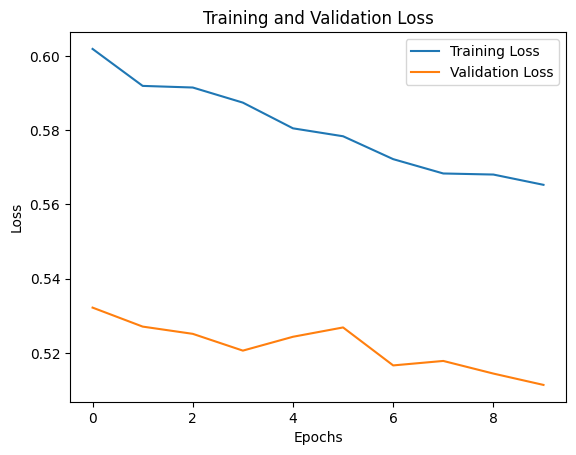

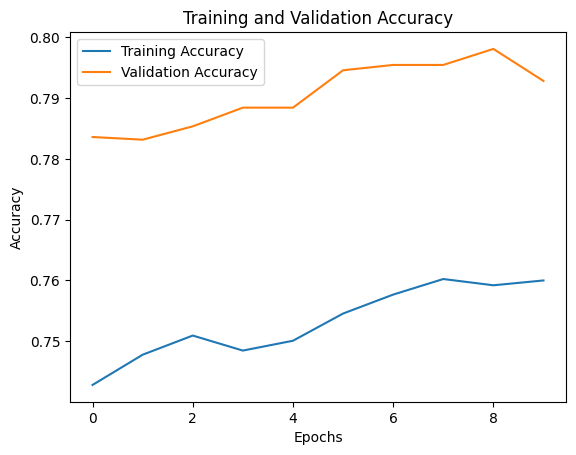

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
model.save('suyash2.keras')

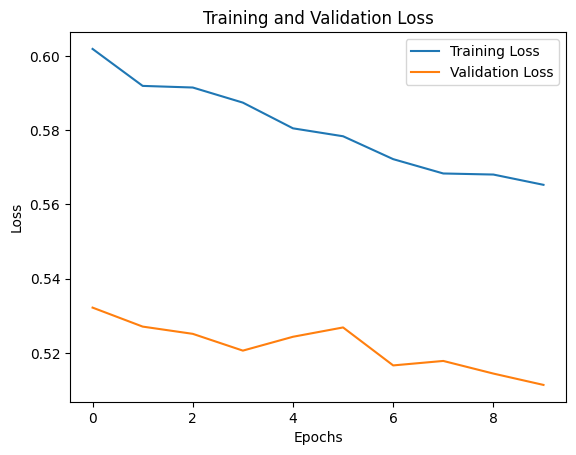

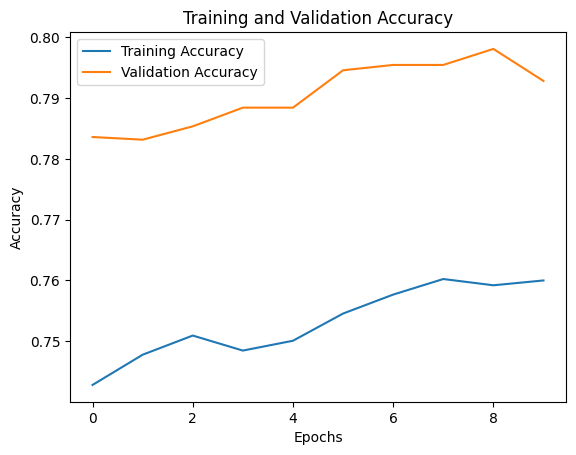

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting the accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


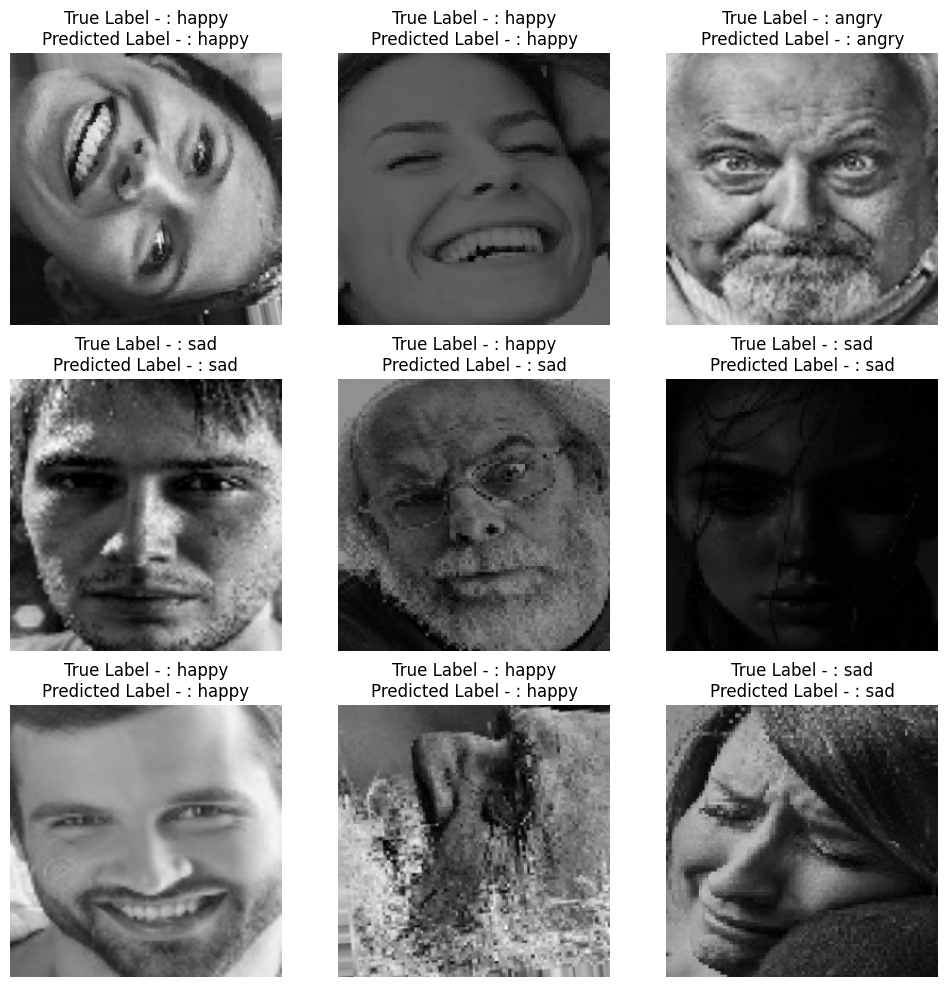

In [33]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CLASS_NAMES[int(tf.argmax(model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

In [30]:
test_image = cv2.imread("/content/path/to/augmented_dataset/angry/101071.jpg_brightness_1_aug_0.jpg")
test_image = cv2.resize(test_image, (IM_SIZE ,IM_SIZE))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(model(im))
print(CLASS_NAMES[tf.argmax(model(im), axis = -1).numpy()[0]])

tf.Tensor([[2.8516066e-01 7.1422863e-01 6.1070122e-04]], shape=(1, 3), dtype=float32)
happy


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━

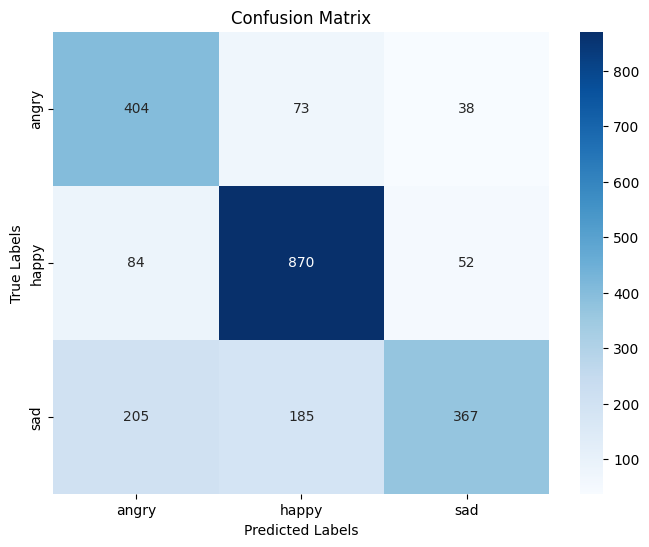

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('suyash.keras')

# Assuming you have your validation dataset named 'validation_dataset'
# Create empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset
for images, labels in validation_dataset:
  # Get predictions from the model
  predictions = model.predict(images)
  # Convert predicted probabilities to class labels
  predicted_labels_batch = np.argmax(predictions, axis=1)
  # Convert true labels from one-hot encoded to class labels
  true_labels_batch = np.argmax(labels.numpy(), axis=1)

  # Append to the lists
  true_labels.extend(true_labels_batch)
  predicted_labels.extend(predicted_labels_batch)


# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()